In [1]:
# Reference: https://www.kaggle.com/kcostya/lstm-models-for-multi-step-time-series-forecast
# https://stackoverflow.com/questions/52778922/stock-prediction-gru-model-predicting-same-given-values-instead-of-future-stoc

# 0.0. IMPORTS
---

In [58]:
# load and clean-up data
import numpy  as np
import pandas as pd

import math

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

## 0.1. Helper Functions

In [53]:
# filling missing values with a value at the same time one day ago
def fill_missing( values ):
    one_day = 60 * 24
    for row in range( values.shape[0] ):
        for col in range( values.shape[1] ):
            if np.isnan( values[row, col] ):
                values[row, col] = values[ row - one_day, col ]
    return values


# split an univariate dataset into training/test sets
def split_dataset( data ):
    # split into standar weeks
    train, test = data[1:-328], data[-328:-6]
    
    # restructure into windows of weekly data
    train = np.array( np.split( train, len( train ) / 7 ) )
    test = np.array( np.split( test, len( test ) / 7 ) )
    
    return train, test


# make a forecast
def forecast( model, history, n_input ):
    # flatten data
    data = np.array( history )
    data = data.reshape( (data.shape[0]*data.shape[1], data.shape[2]) )
    
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape( (1, len( input_x ), 1) )
    
    # forecast the next week
    yhat = model.predict( input_x, verbose=0 )
    
    # we only want the vectr forecast
    yhat = yhat[0]
    
    return yhat
    

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts( actual, predicted ):
    scores = list()
    
    # calculate a RMSE score for eah day
    for i in range( actual.shape[1] ):
        # calculate mse
        mse = mean_squared_error( actual[:, i], predicted[:, i] )
        
        # calculate rmse
        rmse = np.sqrt( mse )
        
        # store
        scores.append( rmse )
        
    # calculate over RMSE
    s = 0
    
    for row in range( actual.shape[0] ):
        for col in range( actual.shape[1] ):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt( s / (actual.shape[0] * actual.shape[1]) )
    
    return score, scores

## 0.2. Loading Data

In [24]:
# load dataset
dataset = pd.read_csv( '../data/household_power_consumption.csv', low_memory=False, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'] )

In [26]:
# mark all missing values
dataset.replace( '?', np.nan, inplace=True )

# make dataset numeric
dataset = dataset.astype( 'float32' )

# fill missing
fill_missing( dataset.values )

# add a column for the reminder of sub metering
values = dataset.values
dataset['sub_metering_4'] = ( values[:, 0] * 1000 / 60 ) - ( values[:,4] + values[:,5] + values[:,6] ) 

# 2.0. DATA PREPARATION
---

In [30]:
# resample minute data to daily
dataset = dataset.resample( 'D' ).sum()

# summarize
print( dataset.shape )

(1442, 8)


In [39]:
train, test = split_dataset( dataset.values )

# validate train data
print( train.shape )
print( train[0, 0, 0], train[-1, -1, 0] )

# validate test
print( test.shape )
print( test[0, 0, 0], test[-1, -1, 0 ] )

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


## 3.0. MACHINE LEARNING MODELLING
---

### 3.1. LSTM with Univariate Input and Vector Output

In [45]:
n_input=7
n_out = 7 

# convert history into inputs and outputs
# flatten data
data = train.reshape( (train.shape[0]*train.shape[1], train.shape[2]) )

X, y = list(), list()

in_start = 0

# step over the entire history one time step at a time
for _ in range( len( data ) ):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    
    # ensure we have enough data for this instance
    if out_end < len( data ):
        x_input = data[in_start:in_end, 0]
        x_input = x_input.reshape( ( len( x_input ), 1 ) )
        
        X.append( x_input )
        y.append( data[in_end:out_end, 0] )
        
    # move along one time step
    in_start += 1
        
# prepare data
train_x, train_y = np.array( X ), np.array( y )

In [47]:
# define parameters
verbose, epochs, batch_size = 1, 70, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add( LSTM( 200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add( Dense( 100, activation='relu' ) )
model.add( Dense( n_outputs ) )

model.compile( loss='mse', optimizer='adam' )

# fit network
model.fit( train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose )

Epoch 1/70
1099/1099 [==============================] - 2s 2ms/step - loss: 844329.9859
Epoch 2/70
1099/1099 [==============================] - 1s 1ms/step - loss: 272510.7966
Epoch 3/70
1099/1099 [==============================] - 1s 1ms/step - loss: 265672.4402
Epoch 4/70
1099/1099 [==============================] - 1s 989us/step - loss: 266409.2063
Epoch 5/70
1099/1099 [==============================] - 1s 968us/step - loss: 266759.0344
Epoch 6/70
1099/1099 [==============================] - 1s 977us/step - loss: 264205.5781
Epoch 7/70
1099/1099 [==============================] - 1s 1ms/step - loss: 261197.1246
Epoch 8/70
1099/1099 [==============================] - 1s 997us/step - loss: 259382.1711
Epoch 9/70
1099/1099 [==============================] - 1s 1ms/step - loss: 257177.6272
Epoch 10/70
1099/1099 [==============================] - 1s 977us/step - loss: 258476.3437
Epoch 11/70
1099/1099 [==============================] - 1s 1ms/step - loss: 255443.4469
Epoch 12/70
1099/109

In [54]:
# history is a list of weekly data
history = [x for x in train]

# walk-forward validation over each week
predictions = list()

n_input = 7
for i in range( len( test ) ):
    # predict the week
    yhat_sequence = forecast( model, history, n_input )
    
    # store the predictions
    predictions.append( yhat_sequence )
    
    # get real observation and add to history for predicting the next week
    history.append( test[i, :] )
    
# evaluate predictions days for each week
predictions = np.array( predictions )

score, scores = evaluate_forecasts( test[:, :, 0], predictions )

In [56]:
# summarize scores
s_scores = ', '.join( ['%.1f' % s for s in scores] )
print( '%s: [%.3f] %s' % ('lstm', score, s_scores) )

lstm: [391.405] 403.8, 412.8, 371.9, 382.1, 399.0, 314.8, 443.2


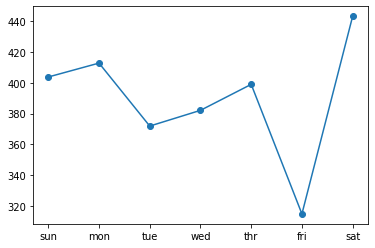

In [60]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot( days, scores, marker='o', label='lstm' )